# Importing libraries, loading and transforming data

In [1]:
!pip install -q mlflow nlp datasets openai

In [2]:
#imports
import pandas as pd
import gc
import re
import numpy as np
import torch
import transformers
from transformers import AutoModel, AutoTokenizer, TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding, AutoModelForSequenceClassification
from huggingface_hub import login
from torch import cuda, bfloat16
from datasets import load_dataset
from nlp import Dataset
from imblearn.over_sampling import RandomOverSampler
import datasets
from transformers import pipeline
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path
import csv
from openai import OpenAI
tqdm.pandas()

In [3]:
# set parameters
train_fraction = 0.7 # fraction of a dataset used for training (the rest used for validation)
num_train_epochs = 3 # epochs to train
batch_size = 16 # batch size for training and validation
warmup_steps = 50
weight_decay = 0.02
distilbert_model = "distilbert-base-cased"
output_dir = "./phishing-email-detection"

In [4]:
dataset = load_dataset("zefang-liu/phishing-email-dataset", trust_remote_code=True)
df = dataset['train'].to_pandas()
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)
print(df.shape)
df.sample(5).T

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/18650 [00:00<?, ? examples/s]

(17539, 2)


,14235,14527,6763,15954,3546
Email Text,URL: http://diveintomark.org/archives/2002/10/...,it ' s time to invest your way our company ' s...,investsource research alerts for maximum capit...,expansion attached please find the tw expansio...,Greetings!You are receiving this letter becaus...
Email Type,Safe Email,Phishing Email,Phishing Email,Safe Email,Phishing Email


In [5]:
# create target
df['label'] = (df['Email Type']=="Phishing Email").astype(int)
df['title'] = df['Email Text']
df = df[['title', 'label']]

print(df.shape)
df.sample(20)

(17539, 2)


,title,label
1674,ets salutes please join me in congratulating l...,0
15023,weekend noms - - - - - - - - - - - - - - - - -...,0
2521,does your business depend on the online succes...,1
15122,grammatical relations and derived notions abou...,0
2274,"\nAlarms, New Hours .htm\n<!--\n /* Style Defi...",1
16537,[ ilug - social ] hello office of : egnr . fem...,1
11683,FIND OUT WHO THEY ARE CHATTING/E-MAILING WITH ...,1
14727,osteoarthritis is painful . relax your muscles...,1
1155,">>>>> ""R"" == Robert Harley writes: R> Anot...",0
7215,re : cleburne pc # - - - - - - - - - - - - - -...,0


In [6]:
# drop null records
df.dropna(inplace=True)
df['label'].mean()

<ipython-input-6-17ea06fec25c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


0.37393089291823467

In [7]:
# random oversampling of minority class
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
print(df.shape)
del y_resampled
gc.collect()

(21960, 2)


36

In [8]:
medium_dataset = Dataset.from_pandas(df)

In [9]:
del df
gc.collect()

0

In [10]:
tokenizer = AutoTokenizer.from_pretrained(distilbert_model, use_fast=True, low_cpu_mem_usage=False)

# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True)

medium_dataset = medium_dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

In [11]:
# Dataset has a built in train test split method
medium_dataset = medium_dataset.train_test_split(test_size=1-train_fraction)
medium_dataset
medium_dataset.remove_column_("title") # remove the text column because we don't need to keep it in memory anymore

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the
#  length of the longest element in the batch, making them all the same length.
#  It's possible to pad text in the tokenizer function with padding=True but dynamic padding is more efficient.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
tokenizer.decode(medium_dataset['train'][0]['input_ids'])

"[CLS] earn 100 k in the next 60 days. ahem you believe youhave the best program on the internet right..... you've captured the marketing giant i you're reaching the masses you have the giant'stools and you know how to use them you've put your heart and soul intoyour enterprise the cold hard cash is rolling in are those the real facts of your business? what if...... you couldrealizeyour dream and really grabthose profits. how do i dothatyou might ask. the million dollar question. themillion dollar answer : a system that virtually guarantees 95 % success in your business using the power of the internet. now you canfinally make it happen wi t ho u t harassing friends and family. spending a fortune on useless lead lists. using amateur strategies and techniques. so what is the bottom line here every business is 20 % product and 80 % marketing. our powerful internet marketing system puts your business in profit and catapultsit into momentum. you deserve success. this is the class act of int

# Loading and training model

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    distilbert_model, num_labels=2,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

model.config.id2label = {0: 'SAFE EMAIL', 1: 'PHISHING EMAIL'}

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

65.783042


In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [17]:
training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    eval_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    save_strategy='epoch',
    report_to="mlflow",  # log to mlflow
)

# Define the trainer, initiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=medium_dataset['train'],
    eval_dataset=medium_dataset['test'],
    data_collator=data_collator
)

In [18]:
# Get initial metrics
trainer.evaluate()

{'eval_loss': 0.692186713218689,
 'eval_model_preparation_time': 0.0016,
 'eval_accuracy': 0.49779936257398694,
 'eval_precision': 0.5642373745154432,
 'eval_recall': 0.49779936257398694,
 'eval_f1': 0.35523588334528744,
 'eval_runtime': 110.864,
 'eval_samples_per_second': 59.433,
 'eval_steps_per_second': 3.716}

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.635900,0.054650,0.001600,0.988010,0.988242,0.988010,0.988011
2,0.000200,0.041029,0.001600,0.991501,0.991530,0.991501,0.991500
3,0.000100,0.034502,0.001600,0.993626,0.993645,0.993626,0.993626


TrainOutput(global_step=2883, training_loss=0.049758026541600005, metrics={'train_runtime': 2744.8706, 'train_samples_per_second': 16.8, 'train_steps_per_second': 1.05, 'total_flos': 6101071677930432.0, 'train_loss': 0.049758026541600005, 'epoch': 3.0})

In [20]:
trainer.evaluate()

{'eval_loss': 0.03450151905417442,
 'eval_model_preparation_time': 0.0016,
 'eval_accuracy': 0.9936257398694794,
 'eval_precision': 0.9936446690585441,
 'eval_recall': 0.9936257398694794,
 'eval_f1': 0.993626048273736,
 'eval_runtime': 124.7433,
 'eval_samples_per_second': 52.82,
 'eval_steps_per_second': 3.303,
 'epoch': 3.0}

# Visualisations

Number of evaluation loss points: 4


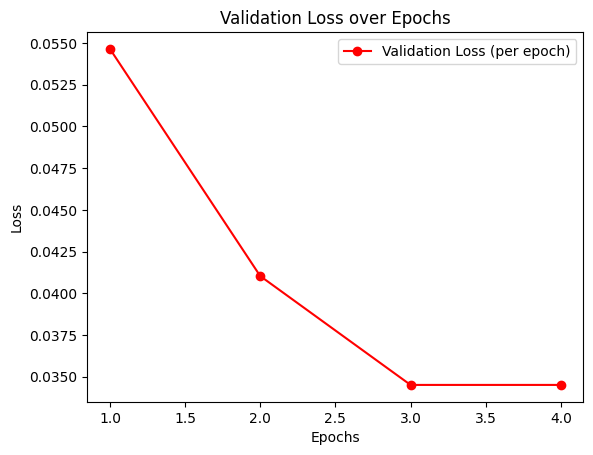

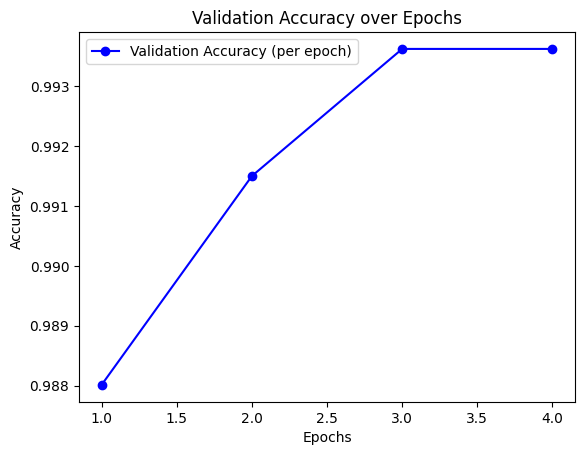

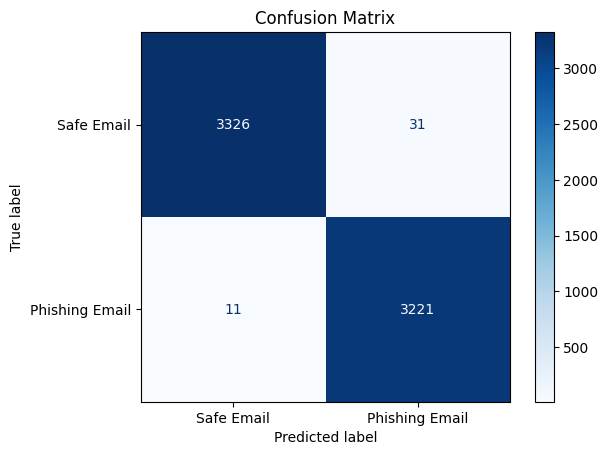

In [21]:
log_history = trainer.state.log_history

eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

print(f"Number of evaluation loss points: {len(eval_loss)}")

# Check how many evaluations happened
epochs_eval = range(1, len(eval_loss) + 1)

plt.plot(epochs_eval, eval_loss, 'ro-', label='Validation Loss (per epoch)')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs_eval, eval_accuracy, 'bo-', label='Validation Accuracy (per epoch)')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

predictions = trainer.predict(medium_dataset['test'])
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = medium_dataset['test']['label']

class_names = ['Safe Email', 'Phishing Email']

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Saving the model and checking its performance with a sample

In [22]:
trainer.save_model()
tokenizer.save_vocabulary(save_directory=output_dir)

('./phishing-email-detection/vocab.txt',)

In [23]:
# make a classification pipeline
pipe = pipeline("text-classification", output_dir, tokenizer=distilbert_model)
sample_title = '''Why do employees leave companies — analysis of IBM employee data'''
pipe(sample_title, top_k=None)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'SAFE EMAIL', 'score': 0.9991666078567505},
 {'label': 'PHISHING EMAIL', 'score': 0.0008334196754731238}]

In [24]:
# use the upper-case version
sample_title2 = sample_title.upper()
pipe(sample_title2, top_k=None)

[{'label': 'PHISHING EMAIL', 'score': 0.9995331764221191},
 {'label': 'SAFE EMAIL', 'score': 0.0004668229375965893}]

In [25]:
# more refined version
sample_title3 = '''Why do employees leave companies?'''
pipe(sample_title3, top_k=None)

[{'label': 'SAFE EMAIL', 'score': 0.9886530041694641},
 {'label': 'PHISHING EMAIL', 'score': 0.011347043327987194}]

In [26]:
# Initialize the OpenAI client
client = OpenAI(api_key="API_KEY")

# Function to validate email address format
def is_valid_email(email):
    return '@' in email and '.' in email

# Function to classify and extract email
def classify_and_extract_email(text, pipe, threshold=0.5):
    results = pipe(text, top_k=None)
    print("Classification results: ", results)
    for result in results:
        if result['label'] == 'PHISHING EMAIL' and result['score'] >= threshold:
            return result
    return results

# Function to generate a counter-response to phishing email using ChatGPT
def generate_counter_response(phishing_email_content):
    prompt = (
        "You are an expert in cybersecurity and email security."
        "Here is a phishing email:\n\n"
        f"{phishing_email_content}\n\n"
        "Craft a response to this phishing email that engages the sender."
        "Your goal is to gather more information about the sender or their intentions."
        "Ensure the response appears interested in the offer, but subtly aims to expose or trap the sender."
        "Avoid directly revealing that you are aware of the phishing attempt."
        "Make the response convincing and professional, encouraging further interaction that could reveal more about the sender’s motives."
    )

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
    )
    return print(response.choices[0].message.content)

# Function to save the phishing email to a CSV file
def save_to_csv(email, subject, content):
    output_file = Path("phishing_emails.csv")

    # Check if the file exists to write header only for the first time
    file_exists = output_file.exists()

    with open(output_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["Email Address", "Subject", "Email Content"])  # Write header if the file is created first time
        writer.writerow([email, subject, content])

# Main program function to get email details and classify it
def main():
  while True:
    # Input email details from the user
    email_address = input("Enter the email address:")
    if not is_valid_email(email_address):
      print("Invalid email address! Please enter a valid email.")
      continue

    subject = input("Enter the subject:")
    email_content = input("Enter the email content:")

    if not email_address or not subject or not email_content:
        print("All fields must be filled!")
        continue

    # Classify the email content
    result = classify_and_extract_email(email_content, classification_pipe)

    if result['label'] == 'PHISHING EMAIL':
        # Generate a counter response using ChatGPT
        print(f"Phishing email detected! \nGenerated response:\n")
        response = generate_counter_response(email_content)

        # Save to CSV
        save_to_csv(email_address, subject, email_content)
        print("Phishing email information saved to CSV.")

    else:
      print("The email is classified as safe.")

    # Option to process another email or exit
    another = input("Do you want to process another email? (yes/no): ").lower()
    if another != 'yes':
      break

# Directory where the model and tokenizer are saved
output_dir = "phishing-email-detection"

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model = AutoModelForSequenceClassification.from_pretrained(output_dir)

# Load the text-classification pipeline
classification_pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Run the main program
if __name__ == "__main__":
    main()

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Enter the email address:test@example.com
Enter the subject:Claim your free gift card!
Enter the email content:Click NOW on the link below to claim your FREE gift card!
Classification results:  [{'label': 'PHISHING EMAIL', 'score': 0.9999134540557861}, {'label': 'SAFE EMAIL', 'score': 8.651556709082797e-05}]
Phishing email detected! 
Generated response:

Subject: Re: Your Fantastic Gift Card Offer

Dear Sender,

I am pleasantly surprised to receive such a generous offer from you. The idea of a free gift card intrigued me and got my full attention. 

Just a few quick questions before I click on the link to claim this wonderful gift. Could you kindly let me know which company you're representing? This way, I can have an idea about the potential options where I can use my gift card.

Secondly, it would be interesting to know how did my profile come up for this lucky selection? I have always tried my luck with various contests and lucky draws, so I’m delightfully thrilled to finally get som